In [1]:
import numpy as np 
import tensorflow 
import pandas as pd
import matplotlib.pyplot as plt 
from tensorflow.keras.datasets.fashion_mnist import load_data 
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Conv2D, \
Conv2DTranspose, LeakyReLU, Dropout, Embedding, Concatenate
from tensorflow.keras.optimizers import Adam

In [2]:
def discriminator(in_shape = (28,28,1), n_classes = 10):
  in_label = Input((1,))
  em = Embedding(n_classes, 50)(in_label)
  n_nodes = in_shape[0] * in_shape[1]
  den = Dense(n_nodes)(em)
  re = Reshape((in_shape[0], in_shape[1], 1))(den)

  in_image = Input((in_shape))

  merge = Concatenate()([in_image, re])

  fe = Conv2D(128, (3,3), strides = (2,2), padding = 'same')(merge)
  fe = LeakyReLU(alpha = 0.2)(fe)
  fe = Conv2D(128, (3,3), strides = (2,2), padding = 'same')(fe)
  fe = LeakyReLU(alpha = 0.2)(fe)
  fe = Flatten()(fe)
  fe = Dropout(0.4)(fe)
  out = Dense(1, activation = 'sigmoid')(fe)

  model = Model([in_image, in_label], out)
  opt = Adam(lr = 0.0002, beta_1 = 0.5)
  model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])

  return model

def generator(latent_dim, n_classes = 10):
  in_label = Input((1,))
  em = Embedding(n_classes, 50)(in_label)
  n_nodes = 7 * 7
  den = Dense(n_nodes)(em)
  li = Reshape((7, 7, 1))(den)
  in_lat = Input((latent_dim,))
  n_nodes = 128 * 7 * 7
  gen = Dense(n_nodes)(in_lat)
  gen = LeakyReLU(alpha = 0.2)(gen)
  gen = Reshape((7, 7, 128))(gen)
  merge = Concatenate()([gen, li])
  gen = Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same')(merge)
  gen = LeakyReLU(alpha = 0.2)(gen)
  gen = Conv2DTranspose(128, (4,4), strides = (2,2), padding = 'same')(gen)
  gen = LeakyReLU(alpha = 0.2)(gen)
  out = Conv2D(1, (7, 7), activation = 'tanh', padding = 'same')(gen)

  model = Model([in_lat, in_label], out)
  return model

def GAN(g_model, d_model):
  d_model.trainable = False
  gen_noise, gen_label = g_model.input 
  gen_output = g_model.output

  gan_output = d_model([gen_output, gen_label])

  model = Model([gen_noise, gen_label], gan_output)

  opt = Adam(lr = 0.0002, beta_1 = 0.5)
  model.compile(loss = 'binary_crossentropy', optimizer = opt)
  return model

In [3]:
def load_real_samples():
  (x_train, y_train), (x_test, y_test) = load_data()
  X = np.expand_dims(x_train, axis = -1)
  X = X.astype('float32')
  X = (X - 127.5) / 127.5
  return [X, y_train]

def generate_real_samples(dataset, n_samples):
  images, labels = dataset
  ix = np.random.randint(0, images.shape[0], n_samples)
  X, labels = images[ix], labels[ix]
  y = np.ones((n_samples, 1))
  return [X, labels], y

def generate_latent_points(latent_dim, n_samples, n_classes = 10):
  x_input = np.random.randn(latent_dim * n_samples)
  z_input = x_input.reshape(n_samples, latent_dim)
  labels = np.random.randint(0, n_classes, n_samples)
  return [z_input, labels]

def generate_fake_examples(generator, latent_dim, n_samples):
  z_input, labels_input = generate_latent_points(latent_dim, n_samples)
  images = generator.predict([z_input, labels_input])
  y = np.zeros((n_samples, 1))
  return [images, labels_input], y

In [6]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs = 100, n_batch = 128):
  batch_per_epoch = int(dataset[0].shape[0] / n_batch)
  half_batch = int(n_batch / 2)
  for i in range(n_epochs): 
    for j in range(batch_per_epoch):

      [x_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
      d_loss1, _ = d_model.train_on_batch([x_real, labels_real], y_real)

      [x_fake, labels], y_fake = generate_fake_examples(g_model, latent_dim, half_batch)
      d_loss2, _ = d_model.train_on_batch([x_fake, labels], y_fake)

      [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
      y_gan = np.ones((n_batch, 1))
      g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

    print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, batch_per_epoch, d_loss1, d_loss2, g_loss))
    g_model.save('cgan_generator.h5')

In [7]:
latent_dim = 100
d_model = discriminator()
g_model = generator(latent_dim)
gan_model = GAN(g_model, d_model)

dataset = load_real_samples()

train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 468/468, d1=0.706, d2=0.644 g=0.795
>2, 468/468, d1=0.676, d2=0.659 g=0.835
>3, 468/468, d1=0.681, d2=0.614 g=0.854
>4, 468/468, d1=0.680, d2=0.679 g=0.790
>5, 468/468, d1=0.670, d2=0.665 g=0.780
>6, 468/468, d1=0.660, d2=0.642 g=0.800
>7, 468/468, d1=0.671, d2=0.661 g=0.777
>8, 468/468, d1=0.646, d2=0.703 g=0.807
>9, 468/468, d1=0.678, d2=0.632 g=0.804
>10, 468/468, d1=0.671, d2=0.659 g=0.771
>11, 468/468, d1=0.676, d2=0.605 g=0.865
>12, 468/468, d1=0.600, d2=0.690 g=0.753
>13, 468/468, d1=0.696, d2=0.699 g=0.755
>14, 468/468, d1=0.670, d2=0.623 g=0.844
>15, 468/468, d1=0.687, d2=0.703 g=0.789
>16, 468/468, d1=0.653, d2=0.656 g=0.762
>17, 468/468, d1=0.685, d2=0.662 g=0.775
>18, 468/468, d1=0.668, d2=0.712 g=0.774
>19, 468/468, d1=0.663, d2=0.653 g=0.772
>20, 468/468, d1=0.667, d2=0.661 g=0.764
>21, 468/468, d1=0.653, d2=0.729 g=0.772
>22, 468/468, d1=0.696, d2=0.641 g=0.795
>23, 468/468, d1=0.686, d2=0.667 g=0.786
>24, 468/468, d1=0.649, d2=0.645 g=0.762
>25, 468/468, d1=0.672, d

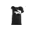

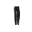

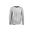

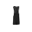

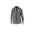

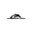

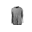

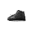

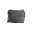

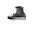

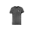

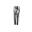

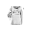

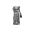

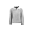

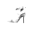

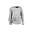

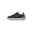

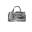

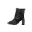

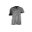

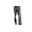

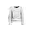

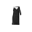

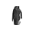

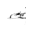

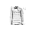

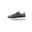

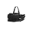

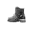

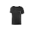

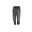

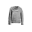

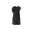

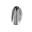

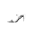

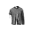

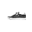

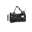

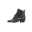

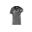

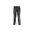

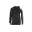

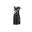

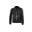

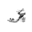

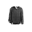

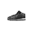

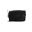

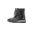

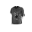

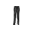

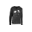

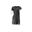

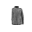

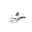

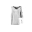

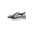

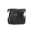

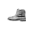

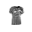

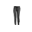

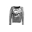

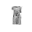

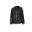

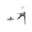

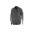

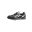

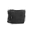

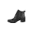

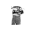

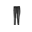

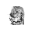

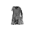

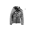

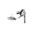

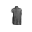

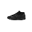

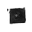

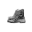

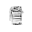

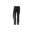

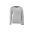

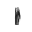

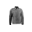

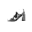

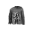

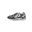

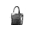

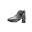

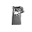

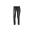

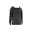

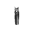

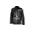

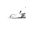

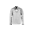

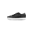

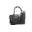

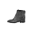

In [15]:
from keras.models import load_model
def save_plot(examples, n):
  for i in range(n * n):
    plt.subplot(n, n, 1+i)
    plt.axis('off')
    plt.imshow(examples[i, :, :, 0], cmap = 'gray_r')
    plt.show()

model = load_model('cgan_generator.h5')
latent_points, labels = generate_latent_points(100, 100)
labels = np.asarray([x for _ in range(10) for x in range(10)])
X = model.predict([latent_points, labels])
X = (X + 1) / 2.0
save_plot(X, 10)